# SI: Anomalous Fibril Length Dependence on Amyloid Adsorption to Charged Interfaces

_Giulio Tesei, Erik Hellstrand, Sara Linse, Emma Sparr, Robert Vacha, and Mikael Lund_

## System Requirements
This Jupyter Notebook was originally run in MacOS 10.11 with `GCC 4.8`, `cmake`, `Python3`, `matplotlib`, `pandas` within the Anaconda environment. Contemporary Linux distributions such as Ubuntu 14.04 will also work.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, shutil
from pathlib import Path
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

## I. Metropolis Monte Carlo (MC) Simulations

### Download and build Faunus

To simulate the interaction of rigid fibrils with a charged, planar surface we use a custom MC program build within the [Faunus framework](http://github.com/mlund/faunus.git). The sections below will fetch the Faunus project and compile the appropriate version of the program.

In [2]:
%%bash -s "$workdir"
cd $1
if [ ! -d "faunus" ]; then
  git clone https://github.com/mlund/faunus.git
  cd faunus
  git checkout dfdddf3
else
  cd faunus
fi
cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on -DMYPLAYGROUND=`pwd`/../mc/ &>/dev/null
make r2s -j4
cd $1

[ 40%] Built target xdrfile
[ 90%] Built target libfaunus
[100%] Built target r2s


### Create slurm submit script for cluster runs
This part is only for performing the calculations on a cluster, here assumed to use `slurm` for submitting jobs. Below you specify number of processers (`-N`), cores (`-n`) and wall time for each job to be submitted.

In [2]:
%%writefile mc/submit.sh
#!/bin/bash
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 01:00:00
../r2s > out

Overwriting mc/submit.sh


### Create Input and run Monte Carlo simulation

This will generate all input for MC simulations as well as loop over the full parameter space.
In the inner loop you may specify if the jobs should be run locally (not recommended) or be submitted to a cluster, assuming you are running this Notebook from a cluster environment.

In [3]:
%cd $workdir
js = {
  "atomlist" : {
    "Na"   :  { "q": 1, "r":1.9, "mw":22.99 },
    "Cl"   :  { "q":-1, "r":1.7, "mw":35.45 },
    "I"    :  { "q":-1, "r":2.0, "mw":1 },
    "SCN"  :  { "q":-1, "r":2.0, "mw":1 },
    "ASP"  :  { "q":-1, "r":3.6, "mw":110 },
    "HASP" :  { "q":0,  "r":3.6, "mw":110 },
    "LASP" :  { "q":2,  "r":3.6, "mw":110 },
    "CTR"  :  { "q":-1, "r":2.0, "mw":16 },
    "HCTR" :  { "q":0,  "r":2.0, "mw":16 },
    "GLU"  :  { "q":-1, "r":3.8, "mw":122 },
    "HGLU" :  { "q":0,  "r":3.8, "mw":122 },
    "LGLU" :  { "q":2,  "r":3.8, "mw":122 },
    "HIS"  :  { "q":0,  "r":3.9, "mw":130 },
    "HHIS" :  { "q":1,  "r":3.9, "mw":130 },
    "NTR"  :  { "q":0,  "r":2.0, "mw":14 },
    "HNTR" :  { "q":1,  "r":2.0, "mw":14 },
    "TYR"  :  { "q":-1, "r":4.1, "mw":154 },
    "HTYR" :  { "q":0,  "r":4.1, "mw":154 },
    "LYS"  :  { "q":0,  "r":3.7, "mw":116 },
    "HLYS" :  { "q":1,  "r":3.7, "mw":116 },
    "CYS"  :  { "q":-1, "r":3.6, "mw":103 },
    "HCYS" :  { "q":0,  "r":3.6, "mw":103 },
    "ARG"  :  { "q":0,  "r":4.0, "mw":144 },
    "HARG" :  { "q":1,  "r":4.0, "mw":144 },
    "ALA"  :  { "q":0,  "r":3.1, "mw":66 },
    "ILE"  :  { "q":0,  "r":3.6, "mw":102 },
    "LEU"  :  { "q":0,  "r":3.6, "mw":102 },
    "MET"  :  { "q":0,  "r":3.8, "mw":122 },
    "PHE"  :  { "q":0,  "r":3.9, "mw":138 },
    "PRO"  :  { "q":0,  "r":3.4, "mw":90 },
    "TRP"  :  { "q":0,  "r":4.3, "mw":176 },
    "VAL"  :  { "q":0,  "r":3.4, "mw":90 },
    "SER"  :  { "q":0,  "r":3.3, "mw":82 },
    "THR"  :  { "q":0,  "r":3.5, "mw":94 },
    "ASN"  :  { "q":0,  "r":3.6, "mw":108 },
    "GLN"  :  { "q":0,  "r":3.8, "mw":120 },
    "GLY"  :  { "q":0,  "r":2.9, "mw":54 }
  }
}
with open('mc/slitpolymer.json', 'w+') as f:
    f.write(json.dumps(js, indent=4))

def mkinput():
    d = {
        'atomlist':               '../slitpolymer.json',
        'loop_macrosteps':        10,
        'loop_microsteps':        micro,
        'temperature':            298,     # Kelvin
        'epsilon_r':              78.9,    # Water dielectric const
        'dh_ionicstrength':       salt,    # mol/l
        'gouychapman_qarea':      rho,     # unitless i.e. e*phi/kT
        'gouychapman_linearize':  'yes',
        'gouychapman_offset':     3,
        'cuboid_len':             -1,      # Box side length Angstrom
        'cuboid_xlen':            2000,
        'cuboid_ylen':            2000,
        'cuboid_zlen':            500,
        'transrot_transdp':       100,     # Molecular translation parameter
        'transrot_rotdp':         6,       # Molecular rotation parameter
        'oligomer':               '../orderedrod.aam',
        'numpep':                 numpep
    }
    f = open('r2s.input', 'w')
    for key,val in d.iteritems():
        f.write('%-30s %s\n' %(key, val))
    f.close()

%cd -q $workdir'/mc'

# parameter space
rho_range    = [266] # surface charge density (angstrom^2/charge)
salt_range   = [0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 1e10] # ionic strength (mol/l)
numpep_range = [2, 4, 8, 16, 32, 64, 128] # fibril length

# run through all parameter space
micro=20000000

if not Path('monte-carlo-data.p').is_file(): # run only if this file is missing (see next section)
    for rho in rho_range:
        for salt in salt_range:
            for numpep in numpep_range:
                pfx='__rho'+str(rho)+'-N'+str(numpep)+'-I'+str(salt)
                if not os.path.isdir(pfx):
                    %mkdir -p $pfx 
                    %cd $pfx
                    mkinput()
                    if shutil.which('sbatch') is not None:
                        !sbatch ../submit.sh  # run on slurm cluster
                    else:
                        !../r2s > out          # run locally
                    %cd -q ..

/Users/mikael/github/faunus-notebooks/fibril-surface


### Read all Distribution Functions and Calculate Surface Excess

We now load all distribution functions into a Pandas object for further analysis. We also integrate the potential of mean force, $w(r)$ to a surface excess,

$$
\Gamma / \rho = \int_{contact}^{\infty} (e^{-w(r)/k_BT} - 1) dr
$$

Note: All loaded MC data will be saved to disk as a _single_ pickle file, `monte-carlo-data.p`. The next time this cell is run, this file will be loaded and no raw MC data is needed.

In [4]:
%cd -q $workdir'/mc'
if Path('monte-carlo-data.p').is_file():
    data = pd.read_pickle('monte-carlo-data.p')
else:
    d = {}
    rho = rho_range[0]
    for salt in salt_range:
        d[salt] = {}
        for numpep in numpep_range:
            pfx='__rho'+str(rho)+'-N'+str(numpep)+'-I'+str(salt)

            distfile=pfx+'/cmdist.dat'
            if os.path.isfile(distfile): 

                r, P = np.loadtxt(distfile, unpack=True) # load data set
                w = -np.log(P) # potential of mean force (PMF)

                # normalize such that w(r)->0 for large r
                m = (r>200) & (r<220)
                if len(w[m])>0:
                    w = w - w[m].mean()

                    # remove tail
                    w = w[r<200]
                    r = r[r<200]

                    # integrate PMF to surface excess
                    gamma = np.trapz( np.expm1(-w), r  )

                    d[salt][numpep] = { 'r': r, 'pmf': w, 'gamma': gamma }
        if len( d[salt] ) > 0:
            d[salt] = pd.Series(d[salt])

    data = pd.DataFrame(d)
    data = data.rename(columns={1e10: r'$\infty$'})
    data.to_pickle('monte-carlo-data.p')
data

,0.06,0.08,0.1,0.15,0.2,0.25,0.27,0.3,$\infty$
2,"{'gamma': 33.0288986409, 'pmf': [8.50479401216...","{'gamma': 13.5412705826, 'pmf': [9.30223759552...","{'gamma': 4.6114558886, 'pmf': [9.24234641947,...","{'gamma': -4.5291367059, 'pmf': [9.45387407214...","{'gamma': -7.83070994719, 'pmf': [10.184706176...","{'gamma': -9.42957724388, 'pmf': [10.475821617...","{'gamma': -9.85431635732, 'pmf': [9.5604514903...","{'gamma': -10.3161761067, 'pmf': [9.7045481720...","{'gamma': -12.3894976239, 'pmf': [10.402050596..."
4,"{'gamma': 211.471945013, 'pmf': [9.58544039443...","{'gamma': 77.2298192705, 'pmf': [6.53158247748...","{'gamma': 34.5195731218, 'pmf': [7.70850627417...","{'gamma': 3.95756680989, 'pmf': [8.76653422478...","{'gamma': -4.00551810106, 'pmf': [8.4143081701...","{'gamma': -7.45125890754, 'pmf': [11.865952825...","{'gamma': -8.0059254667, 'pmf': [8.80725390389...","{'gamma': -9.05538496976, 'pmf': [11.869390742...","{'gamma': -11.6166684421, 'pmf': [9.3904738469..."
8,"{'gamma': 5698.69384011, 'pmf': [4.51730201877...","{'gamma': 923.708344091, 'pmf': [6.35291798691...","{'gamma': 267.439063534, 'pmf': [7.06439238596...","{'gamma': 37.9223503514, 'pmf': [9.24664408792...","{'gamma': 7.77785956125, 'pmf': [9.05381243038...","{'gamma': -0.953377768947, 'pmf': [9.300497383...","{'gamma': -2.71723485732, 'pmf': [9.5020551622...","{'gamma': -4.60559965483, 'pmf': [9.4754044307...","{'gamma': -9.66073998493, 'pmf': [9.8473404005..."
16,"{'gamma': 81471.1788776, 'pmf': [-2.6250033104...","{'gamma': 5491.3296417, 'pmf': [0.175028208968...","{'gamma': 961.606830339, 'pmf': [2.22640755765...","{'gamma': 82.8388682054, 'pmf': [5.49928435725...","{'gamma': 18.1960163118, 'pmf': [6.49411805865...","{'gamma': 3.34179943852, 'pmf': [6.91633293591...","{'gamma': 0.561684094595, 'pmf': [7.0812537572...","{'gamma': -2.15762569866, 'pmf': [7.0417550383...","{'gamma': -9.12250741359, 'pmf': [10.114698956..."
32,"{'gamma': 22193051.0575, 'pmf': [-10.247000536...","{'gamma': 180958.546699, 'pmf': [-3.6234174346...","{'gamma': 8428.12171181, 'pmf': [-1.4833666670...","{'gamma': 164.51994499, 'pmf': [5.34493144658,...","{'gamma': 18.7318161041, 'pmf': [4.26370804695...","{'gamma': -3.56013070408, 'pmf': [10.819483564...","{'gamma': -7.06277339796, 'pmf': [9.3869751951...","{'gamma': -10.2331144383, 'pmf': [6.6744897150...","{'gamma': -17.4881298867, 'pmf': [13.048542697..."
64,NaN,NaN,"{'gamma': 268936009.296, 'pmf': [-16.440813167...","{'gamma': 20390.4356208, 'pmf': [-6.2460465359...","{'gamma': 203.513784961, 'pmf': [-0.9173383421...","{'gamma': -7.82372121459, 'pmf': [2.1250188990...","{'gamma': -18.7737216283, 'pmf': [4.8589597938...","{'gamma': -26.3178488185, 'pmf': [5.0262915867...","{'gamma': -36.592196391, 'pmf': [9.74436697191..."
128,NaN,"{'gamma': 400007218.87, 'pmf': [-19.3780192339...","{'gamma': 344794069.377, 'pmf': [-11.724108246...","{'gamma': 33577311.0198, 'pmf': [-9.3684884940...","{'gamma': 9553.74342823, 'pmf': [-6.3552756535...","{'gamma': 52.1983173345, 'pmf': [-0.7246725430...","{'gamma': -30.4255693772, 'pmf': [0.6667620937...","{'gamma': -58.137779926, 'pmf': [3.29297601485...","{'gamma': -73.9849114684, 'pmf': [11.762634077..."


### Fibril-Surface Interaction Free Energy

This will plot the potential of mean force (PMF) obtained from MC simulations at different fibril lenghts.

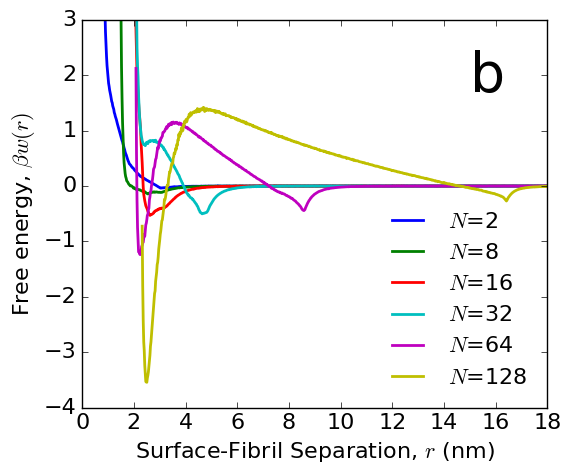

In [5]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})

for N, d in data[0.25].iteritems(): # at 0.25 mol/l salt
    if N in [2,8,16,32,64,128]:
        if type(d)!=type(float()):
            plt.plot( d['r']*0.1, d['pmf'], label='$N$='+str(N), lw=2)

plt.legend(loc=0, frameon=False, fontsize='medium')
plt.xlabel(r'Surface-Fibril Separation, $r$ (nm)')
plt.ylabel(r'Free energy, $\beta w(r)$')
plt.ylim((-4,3))
plt.xlim((0,18))
plt.text(15,1.7,'b',fontsize=40)
plt.savefig('mc_pmf.pdf', bbox_inches='tight')

### Surface Excess at Different Salt Concentrations and Fibril Lengths

/Users/mikael/github/faunus-notebooks/fibril-surface/mc


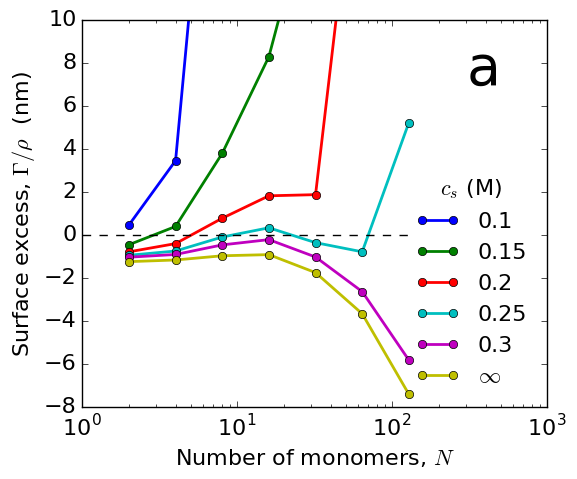

In [6]:
for salt, d in data.items():
    if str(salt) in ['0.1', '0.15', '0.2', '0.25', '0.3', r'$\infty$']:
        N = d.keys()    
        gamma = np.array( [ i['gamma'] for i in d.get_values() if type(i)==dict] )
        plt.plot(N, gamma*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=6)

plt.plot( [0,128], [0,0], 'k--')
plt.legend(loc='lower right',frameon=False, fontsize='medium', title=r'$c_{s}$ (M)')        
plt.xlabel(r'Number of monomers, $N$')
plt.ylabel(r'Surface excess, $\Gamma/\rho$  (nm)')
plt.xscale('log')
plt.ylim((-8,10))
plt.xlim(1, 1000)
plt.text(300,7,'a',fontsize=40)
print(os.getcwd())
plt.savefig('mc_excess.pdf', bbox_inches='tight')

## II. Line Segment Model

Here we calculate the surface excess using a simplified model, considering Gouy-Chapman electrostatics and the excluded volume of a rod approaching a planar surface. As detailed in the main text, the free energy can be approximated with
$$
\beta w(r)^{\scriptsize{\mbox{rod}}} \approx  - 2 z \ln \left[ \frac{1+\tanh (\beta \phi e /4)e^{-\frac{r+s}{\lambda_D}}}{1-\tanh (\beta \phi e /4)e^{-\frac{r+s}{\lambda_D}}} \right] - \ln(2r/L) \vee 0
+ (s/r)^{9}
$$

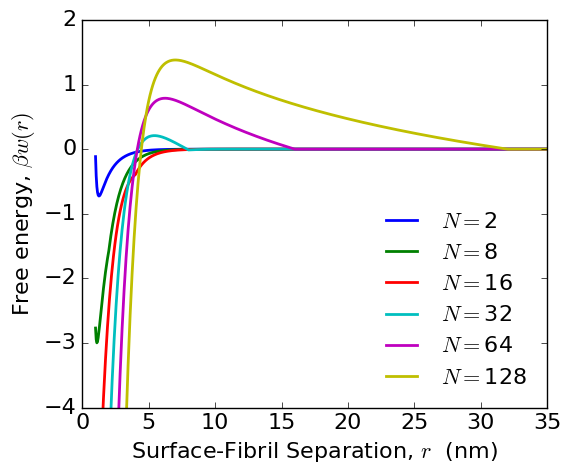

In [7]:
%cd -q $workdir
from math import asinh, sqrt, pi
s=10    # closest contact (Å)
lm=5    # monomer length (Å)
zm=2    # monomer charge (e)
lB=7.1  # Bjerrum length (Å)
NA=6.022e23 # Avogadros number (1/mol)

def TdS(r, L):
    """ rod-2-surface excluded volume contribution to free energy (kT) """
    sel = r<0.5*L
    w   = -np.log(2*r[sel]/L)
    return np.concatenate((w, 0*r[~sel]))

for rho in [266]:
    for N in [2,8,16,32,64,128]:  # number of monomers
        for salt in [0.1]:        # ionic strength (mol/l)
            L = N*lm              # rod length (Å)
            z = zm*N              # rod charge (e)
            lD = 3.04/sqrt(salt)  # Debye length (Å)
            phi = 2*asinh( (1/rho)*sqrt(pi*lB/(2*salt*NA*1e-27)) ) # surf. potential (kT/e)
            r = np.arange(s, 400, 0.5)
            #w = -z * phi * np.exp(-(r+s)/lD) + TdS(r,L)
            w = - 2 * z * np.log( ( 1 + np.tanh( phi / 4 ) * np.exp(-(r+s)/lD) ) 
                             / ( 1 - np.tanh( phi / 4 ) * np.exp(-(r+s)/lD) ) ) + TdS(r,L)+ (s/r)**9
            gamma = np.trapz( np.expm1(-w), r  )
            plt.plot(r*0.1, w, label=r'$N=$'+str(N), lw=2)
            
plt.legend(loc=0,frameon=False, fontsize='medium')
plt.xlabel('Surface-Fibril Separation, $r$  (nm)')
plt.ylabel(r'Free energy, $\beta w(r)$')
plt.xlim((0,35))
plt.ylim((-4,2))
plt.show()

In [8]:
from pylab import cm, imshow, contour, clabel, colorbar

x = np.linspace(0.05,0.45, 221) # salt concentration
y = np.linspace(1, 100, 160) # number of monomers
Z = np.ndarray(shape=(y.size,x.size))
rho = 266

for N in y:                   # number of monomers
    for salt in x:            # ionic strength (mol/l)
        L = N*lm              # rod length (Å)
        z = zm*N              # rod charge (e)
        lD = 3.04/sqrt(salt)  # Debye length (Å)
        phi = 2*asinh( (1/rho)*sqrt(pi*lB/(2*salt*NA*1e-27)) ) # surf. potential (kT/e)
        r = np.arange(0, 1000, 0.2)
        # eq 62. DOI: http://dx.doi.org/10.1016/S0006-3495(02)75375-7
        w = - 2 * z * np.log( ( 1 + np.tanh( phi / 4 ) * np.exp(-(r+s)/lD) ) 
                             / ( 1 - np.tanh( phi / 4 ) * np.exp(-(r+s)/lD) ) ) + TdS(r,L)+ (s/r)**9
        #w = -z * phi * np.exp(-(r+s)/lD) + TdS(r,L)+ (s/r)**9
        exc = np.trapz( np.expm1(-w), r  )*0.1
        Z[y.tolist().index(N)][x.tolist().index(salt)]=exc

/Users/mikael/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/Users/mikael/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide


-12.3126785572


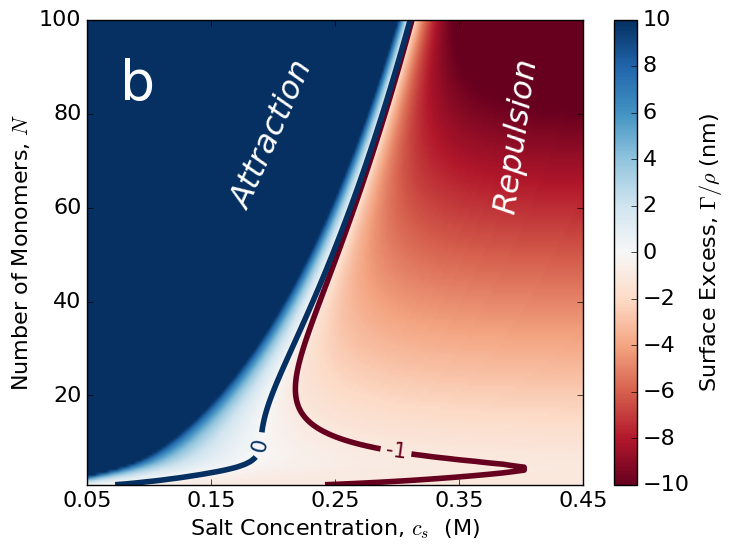

In [238]:
vmin=-10
vmax=10

print(Z.min())

im = imshow(Z,cmap=cm.RdBu,extent=[x.min(),x.max(),y.min(),y.max()],origin='lower',aspect='auto', vmin=vmin, vmax=vmax) 

# contour lines
cset = contour(x, y, Z, (-1,0), linewidths=4, cmap=cm.RdBu)
manual_locations = [(0.3, 10),(0.18, 10)]
clabel(cset, inline=True, fmt='%1.f', fontsize=15, manual=manual_locations)

plt.figtext(0.3,0.8,'Attraction',rotation='66', color='white',fontsize='x-large', style='italic')
plt.figtext(0.63,0.8,'Repulsion',rotation='82',color='white',fontsize='x-large', style='italic')

# labels
colorbar(im,ticks=np.arange(-10,12,2),label=r'Surface Excess, $\Gamma/\rho$ (nm)') # adding the colorbar on the right
plt.ylabel('Number of Monomers, $N$')
plt.xlabel('Salt Concentration, $c_s$  (M)')
plt.xticks(np.arange(.05,.50,.1))
plt.text(0.077,83,'b',fontsize=40,color='w')
plt.savefig('map.png')
plt.show()

/Users/mikael/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/Users/mikael/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


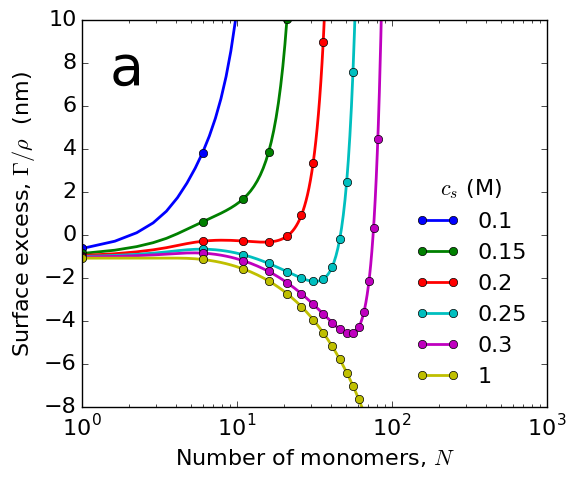

In [9]:
y = np.linspace(1, 100, 160) # number of monomers
salt = [0.1, 0.15, 0.2, 0.25, 0.3, 1]
for cs in salt:
    salt = 0.25  
    Y = []
    X = []
    for N in y:               # number of monomers
        L = N*lm              # rod length (Å)
        z = zm*N              # rod charge (e)
        lD = 3.04/sqrt(cs)    # Debye length (Å)
        phi = 2*asinh( (1/rho)*sqrt(pi*lB/(2*salt*NA*1e-27)) ) # surf. potential (kT/e)
        r = np.arange(0, 1000, 0.2)
        #w = - 2 * z * np.log( ( 1 + np.tanh( phi / 4 ) * np.exp(-(r+s)/lD) ) 
        #                     / ( 1 - np.tanh( phi / 4 ) * np.exp(-(r+s)/lD) ) ) + TdS(r,L) + (s/r)**9
        w = -z * phi * np.exp(-(r+s)/lD) + TdS(r,L) + (s/r)**9
        exc = np.trapz( np.expm1(-w), r  )
        Y.append(N)
        X.append(exc*0.1)
    plt.plot(Y,X, label=cs, linestyle='-', marker='o', lw=2, ms=6, markevery = 8)

plt.legend(loc='lower right',frameon=False, fontsize='medium', title=r'$c_{s}$ (M)')
plt.ylim(-8,10)
plt.xlim(1,1000)
plt.xlabel(r'Number of monomers, $N$')
plt.ylabel(r'Surface excess, $\Gamma/\rho$  (nm)')
plt.xscale('log')
plt.text(1.5,7,'a',fontsize=40)
plt.savefig('linesegment_excess.pdf')
plt.show()

## III. Quartz Crystal Microbalance Dissipation (QCM-D)

In this section we load and plot QCM data.

In [14]:
F50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,1,6,9))
D50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,3,7,11))
Fit50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,2,4,6,8,10,12))
shear50fib = np.loadtxt('exp/par50fib_1.dat',comments={'t'},usecols=(0,1,3,5))
mass50fib = np.loadtxt('exp/par50fib_1.dat',comments={'t'},usecols=(0,2,4,6))

F50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,1,6,9))
D50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,3,7,11))
Fit50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,2,4,6,8,10,12))
shear50fib2 = np.loadtxt('exp/par50fib_2.dat',comments={'t'},usecols=(0,1,3,5))
mass50fib2 = np.loadtxt('exp/par50fib_2.dat',comments={'t'},usecols=(0,2,4,6))

F50mon = np.loadtxt('exp/50mon.dat',comments={'T'},usecols=(0,1,3,5))
D50mon = np.loadtxt('exp/50mon.dat',comments={'T'},usecols=(0,2,4,6))

F200fib = np.loadtxt('exp/200fib.dat',comments={'T'},usecols=(0,3,5,7))
D200fib = np.loadtxt('exp/200fib.dat',comments={'T'},usecols=(0,4,6,8))

F200mon = np.loadtxt('exp/200mon.dat',comments={'T'},usecols=(0,1,3,5))
D200mon = np.loadtxt('exp/200mon.dat',comments={'T'},usecols=(0,2,4,6))

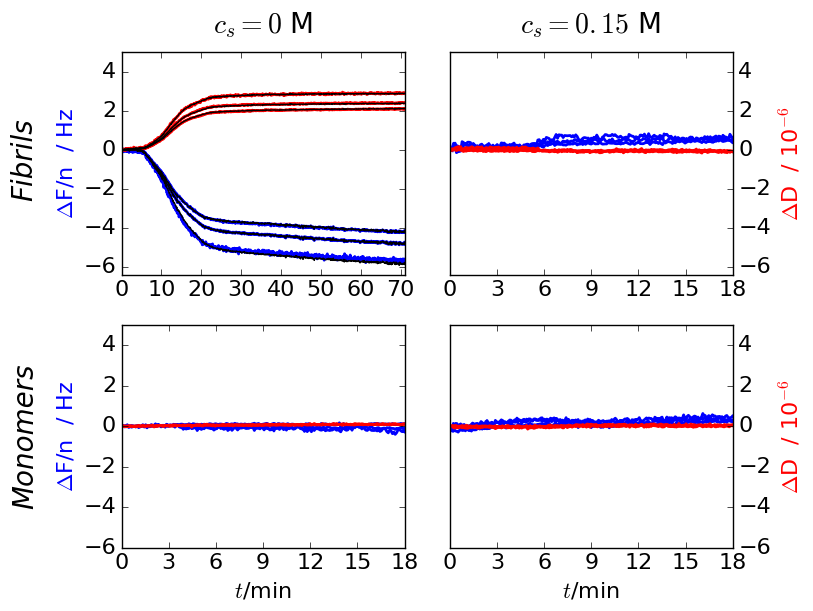

In [17]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
f = plt.figure()

xticks = np.arange(0,19,3)

# 50 mM fibrils
ax = f.add_subplot(221)
#ax.patch.set_alpha(0.05)
#ax.patch.set_color('b')
plt.ylim(-6.4,5)
ax.text(-28,0.5,'Fibrils',rotation=90,fontsize=20, style='italic')
ax.text(23,6,'$c_s = 0$ M',fontsize=20)
plt.xlim(0,71)
plt.ylabel("$\Delta$F/n  / Hz",color='blue')
plt.plot(F50fib[1:,0]/60,F50fib[1:,:],color='blue', lw=2)
plt.plot(D50fib[1:,0]/60,D50fib[1:,:],color='red', lw=2)
plt.plot(Fit50fib[1:,0]/60,Fit50fib[1:,:],color='black', lw=1)

# 200 mM fibrils
ax = f.add_subplot(222)
plt.xticks(xticks)
#ax.patch.set_alpha(0.05)
#ax.patch.set_color('r')
ax.text(4.5,6,'$c_s = 0.15$ M',fontsize=20)
ax.yaxis.tick_right()
plt.ylim(-6.4,5)
plt.xlim(0,18)
plt.ylabel("$\Delta$D  / 10$^{-6}$",color='red')
ax.yaxis.set_label_position("right")
plt.plot(F200fib[1:,0]/60,F200fib[1:,:],color='blue', lw=2)
plt.plot(D200fib[1:,0]/60,D200fib[1:,:],color='red', lw=2)

# 50 mM monomers
ax = f.add_subplot(223)
plt.xticks(xticks)
#ax.patch.set_alpha(0.05)
#ax.patch.set_color('r')
ax.text(-7,2,'Monomers',rotation=90,fontsize=20, style='italic')
plt.ylim(-6,5)
plt.xlim(0,18)
plt.ylabel("$\Delta$F/n  / Hz",color='blue')
plt.xlabel("$t$/min")
plt.plot(F50mon[1:,0]/60,F50mon[1:,:],color='blue', lw=2)
plt.plot(D50mon[1:,0]/60,D50mon[1:,:],color='red', lw=2)

# 200 mM monomers
ax = f.add_subplot(224)
plt.xticks(xticks)
#ax.patch.set_alpha(0.05)
#ax.patch.set_color('r')
ax.yaxis.tick_right()
plt.ylim(-6,5)
plt.xlim(0,18)
plt.ylabel("$\Delta$D  / 10$^{-6}$",color='red')
ax.yaxis.set_label_position("right")
plt.xlabel("$t$/min")
plt.plot(F200mon[2:,0]/60,F200mon[2:,:],color='blue', lw=2)
plt.plot(D200mon[2:,0]/60,D200mon[2:,:],color='red', lw=2)

f.tight_layout()
f.savefig('qcm-d.pdf', bbox_inches='tight', pad_inches=0.3)
plt.show()

### III.1 Analysis of QCM-D data for different batches of sonicated fibrils

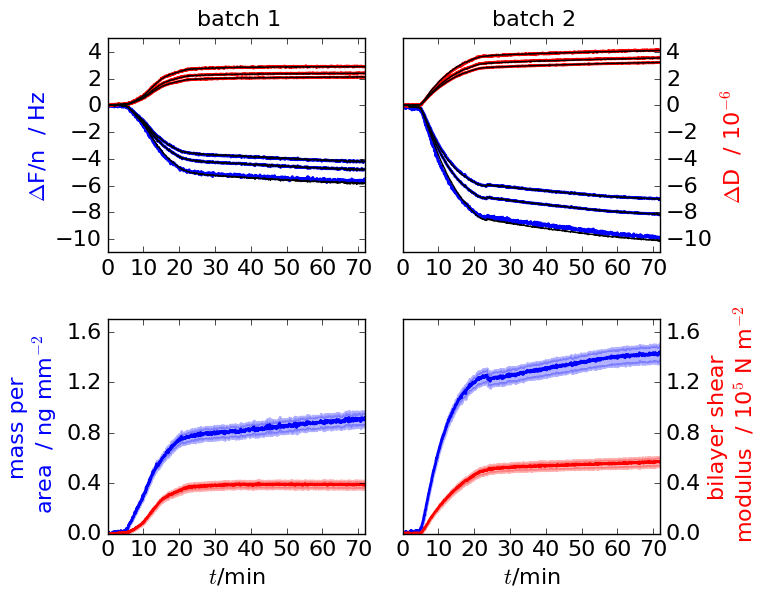

In [16]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
f = plt.figure()

xticks = np.arange(0,19,3)

# 50 mM fibrils, batch 1
ax = f.add_subplot(221)
plt.ylim(-11,5)
ax.text(25,6,'batch 1',fontsize=16)
plt.xlim(0,72)
plt.ylabel("$\Delta$F/n  / Hz",color='blue')
plt.plot(F50fib[1:,0]/60,F50fib[1:,:],color='blue', lw=2)
plt.plot(D50fib[1:,0]/60,D50fib[1:,:],color='red', lw=2)
plt.plot(Fit50fib[1:,0]/60,Fit50fib[1:,:],color='black', lw=1)

# 50 mM fibrils, batch 2
ax = f.add_subplot(222)
ax.text(25,6,'batch 2',fontsize=16)
ax.yaxis.tick_right()
plt.ylim(-11,5)
plt.xlim(0,72)
plt.ylabel("$\Delta$D  / 10$^{-6}$",color='red')
ax.yaxis.set_label_position("right")
plt.plot(F50fib2[1:,0]/60,F50fib2[1:,:],color='blue', lw=2)
plt.plot(D50fib2[1:,0]/60,D50fib2[1:,:],color='red', lw=2)
plt.plot(Fit50fib2[1:,0]/60,Fit50fib2[1:,:],color='black', lw=1)

# mass per area and shear modulus, batch 1
ax = f.add_subplot(223)
plt.yticks(np.arange(0,1.8,0.4))
plt.ylim(0,1.7)
plt.xlim(0,72)
plt.ylabel("mass per\n area  / ng mm$^{-2}$",color='blue')
plt.xlabel("$t$/min")
plt.plot(mass50fib[20:,0]/60-mass50fib[20,0]/60,
         (mass50fib[20:,1:]-mass50fib[20,1]).mean(axis=1),color='blue',lw=2)
plt.fill_between(mass50fib[20:,0]/60-mass50fib[20,0]/60,
         (mass50fib[20:,1:]-mass50fib[20,1]).mean(axis=1)
        +(mass50fib[20:,1:]-mass50fib[20,1]).std(axis=1),
         (mass50fib[20:,1:]-mass50fib[20,1]).mean(axis=1)
        -(mass50fib[20:,1:]-mass50fib[20,1]).std(axis=1),color='blue',lw=2,alpha=.3)
plt.plot(shear50fib[20:,0]/60-shear50fib[20,0]/60,
         (shear50fib[20:,1:]-shear50fib[20,1]).mean(axis=1),color='red', lw=2)
plt.fill_between(shear50fib[20:,0]/60-shear50fib[20,0]/60,
         (shear50fib[20:,1:]-shear50fib[20,1]).mean(axis=1)
        +(shear50fib[20:,1:]-shear50fib[20,1]).std(axis=1),
         (shear50fib[20:,1:]-shear50fib[20,1]).mean(axis=1)
        -(shear50fib[20:,1:]-shear50fib[20,1]).std(axis=1),color='red',lw=2,alpha=.3)

# mass per area and shear modulus, batch 2
ax = f.add_subplot(224)
plt.yticks(np.arange(0,1.8,0.4))
ax.yaxis.tick_right()
plt.ylim(0,1.7)
plt.xlim(0,72)
plt.ylabel("bilayer shear\n modulus  / 10$^{5}$ N m$^{-2}$",color='red',size=16)
ax.yaxis.set_label_position("right")
plt.xlabel("$t$/min")
plt.plot(mass50fib2[40:,0]/60-mass50fib2[40,0]/60,
         (mass50fib2[40:,1:]-mass50fib2[40,1]).mean(axis=1),color='blue', lw=2)
plt.fill_between(mass50fib2[40:,0]/60-mass50fib2[40,0]/60,
         (mass50fib2[40:,1:]-mass50fib2[40,1]).mean(axis=1)
        +(mass50fib2[40:,1:]-mass50fib2[40,1]).std(axis=1),
         (mass50fib2[40:,1:]-mass50fib2[40,1]).mean(axis=1)
        -(mass50fib2[40:,1:]-mass50fib2[40,1]).std(axis=1),color='blue',lw=2,alpha=.3)
plt.plot(shear50fib2[40:,0]/60-shear50fib2[40,0]/60,
         (shear50fib2[40:,1:]-shear50fib2[40,1]).mean(axis=1),color='red', lw=2)
plt.fill_between(shear50fib2[40:,0]/60-shear50fib2[40,0]/60,
         (shear50fib2[40:,1:]-shear50fib2[40,1]).mean(axis=1)
        +(shear50fib2[40:,1:]-shear50fib2[40,1]).std(axis=1),
         (shear50fib2[40:,1:]-shear50fib2[40,1]).mean(axis=1)
        -(shear50fib2[40:,1:]-shear50fib2[40,1]).std(axis=1),color='red',lw=2,alpha=.3)

f.tight_layout()
f.savefig('qcm-d_SI.pdf', bbox_inches='tight', pad_inches=0.3)
plt.show()